In [9]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)


1.13.1+cu116
0.13.1+cu116
cpu


In [2]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [3]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [4]:
IPython.display.Audio(SPEECH_FILE)

In [5]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)


In [6]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

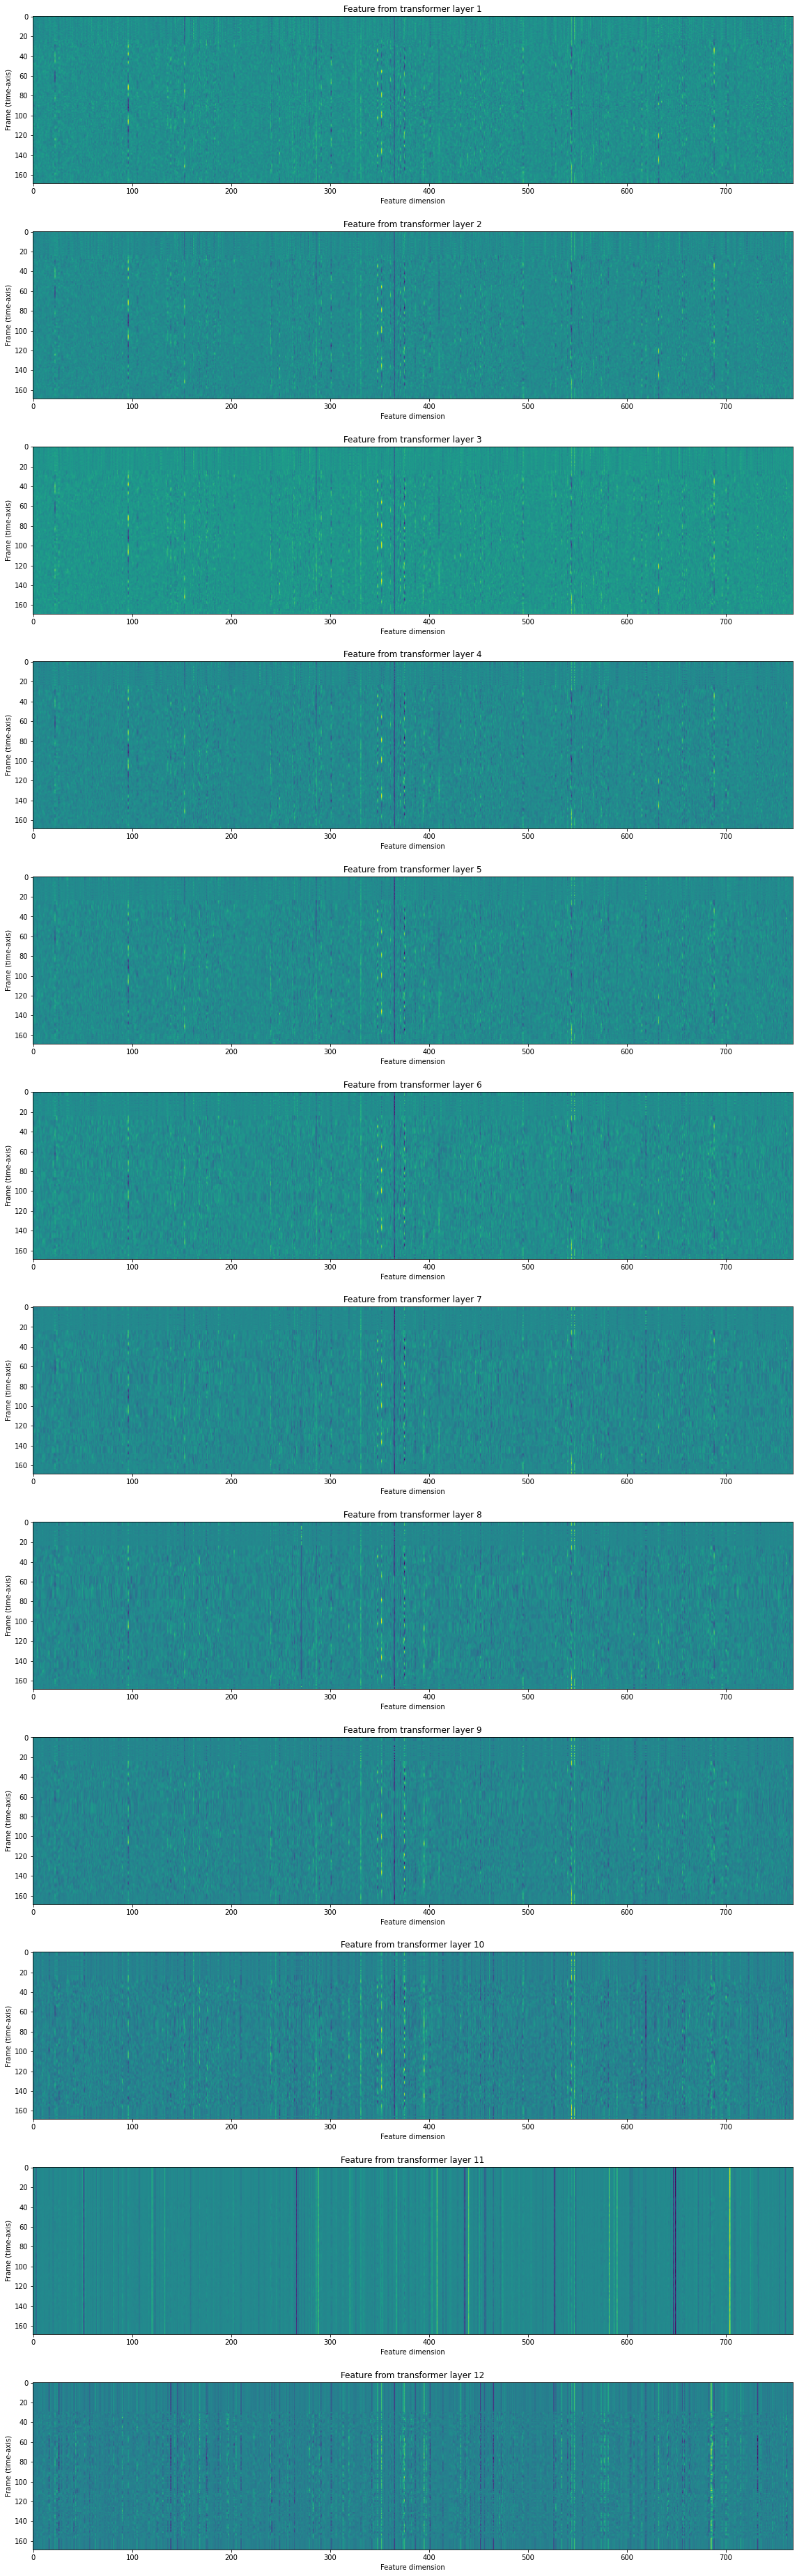

In [7]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [8]:
with torch.inference_mode():
    emission, _ = model(waveform)

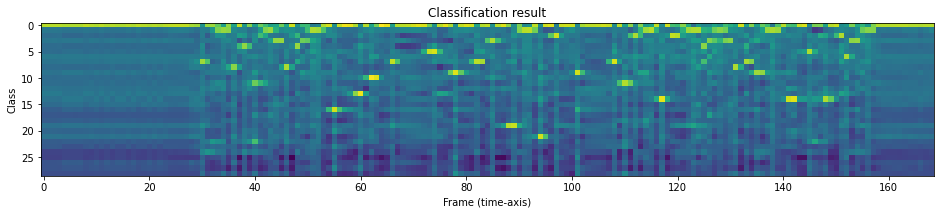

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [10]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [11]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [12]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [13]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [18]:
model_path = '/content/asr.onnx'

In [22]:
model.save_pretrained(model_path)

AttributeError: ignored

In [16]:
##inference
import onnx
MODEL_PATH = '/content/asr.onnx'
onnx_model = onnx.load(MODEL_PATH)
onnx.checker.check_model(onnx_model)
onnx_model.graph.input

FileNotFoundError: ignored

In [15]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import onnxruntime
import os
import time
device_name = 'cpu'
sess_options = onnxruntime.SessionOptions()
sess_options.optimized_model_filepath = os.path.join('/content/sample_data', "/content/asr.onnx".format(device_name))
#sess_options.intra_op_num_threads=psutil.cpu_count(logical=True)

ort_session = onnxruntime.InferenceSession(MODEL_PATH, sess_options)
start = time.time()
ort_outputs = ort_session.run(None, {"onnx::Unsqueeze_0" : input_values.numpy()})
print(ort_outputs)
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.decode(predicted_ids[0])
print(transcription.lower())
print(f"Time taken is {time.time() - start} ms")

In [ ]:
!wget https://lingualibre.org/datasets/Q123270-mis-British%20English.zip 

In [ ]:
!unzip '/content/Q123270-mis-British English.zip'

In [ ]:
if len(speech.shape) > 1: 
        speech = speech[:,0] + speech[:,1]

In [ ]:
if fs != 16000:
        speech = librosa.resample(speech, fs, 16000)

In [ ]:
input_values = tokenizer(speech, return_tensors="pt").input_values

In [ ]:
logits = model(input_values).logits

In [ ]:
predicted_ids = torch.argmax(logits, dim=-1)

In [ ]:
transcription = tokenizer.decode(predicted_ids[0])

In [ ]:
transcription.lower()

In [ ]:
x = asr_transcript("/content/moveright.wav")

In [ ]:
x

In [ ]:
r = asr_transcript("/content/right.wav")

In [ ]:
l = asr_transcript("/content/left.wav")

In [ ]:
u = asr_transcript("/content/up.wav")

In [ ]:
d = asr_transcript("/content/down.wav")

In [ ]:
m = asr_transcript("/content/multi.wav")

In [ ]:
r

In [ ]:
l

In [ ]:
u

In [ ]:
d

In [ ]:
m

In [ ]:
ld = asr_transcript("/content/lokesh_down.wav")

In [ ]:
ld

In [ ]:
rmd = asr_transcript("/content/rmd.wav")

In [ ]:
rmd

In [ ]:
k2 = asr_transcript("/content/jackhammer.wav")

In [ ]:
k2

In [ ]:
from wav2letter.criterion import CpuViterbiPath, get_data_ptr_as_bytes

In [ ]:
!pip install wav2letter

In [ ]:
import time
start = time.time()
## Code
end = time.time()
diff = end - start

In [23]:
!pip install transformers onnxruntime onnx pythainlp soundfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 9.3 MB/s eta 0:00:00


In [24]:
import transformers
from transformers import AutoTokenizer, Wav2Vec2ForCTC
from torchaudio.models.wav2vec2.utils import import_huggingface_model

In [26]:
original = Wav2Vec2ForCTC.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")
imported = import_huggingface_model(original) # Build Wav2Vec2Model fro


/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:375: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [27]:
imported.eval() # set the model to inference mode

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
      )
      (1): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (2): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (3): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (4): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (5): ConvLayerBlock(
        (lay

In [28]:
import torch.onnx

In [29]:
input_size = 100000
AUDIO_MAXLEN = input_size

In [30]:
dummy_input = torch.randn(1, input_size, requires_grad=True)

In [31]:
torch.onnx.export(imported,         # model being run
         dummy_input,       # model input (or a tuple for multiple inputs)
         "asr3.onnx",       # where to save the model
         export_params=True,  # store the trained parameter weights inside the model file
         opset_version=10,    # the ONNX version to export the model to
         do_constant_folding=True,  # whether to execute constant folding for optimization
         input_names = ['modelInput'],   # the model's input names
         output_names = ['modelOutput'], # the model's output names
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes
                                'modelOutput' : {0 : 'batch_size'}})

In [32]:
!wget https://www.dropbox.com/s/9kpeh8eodshcqhj/common_voice_th_23646850.wav?dl=1

--2023-02-05 06:11:48--  https://www.dropbox.com/s/9kpeh8eodshcqhj/common_voice_th_23646850.wav?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9kpeh8eodshcqhj/common_voice_th_23646850.wav [following]
--2023-02-05 06:11:48--  https://www.dropbox.com/s/dl/9kpeh8eodshcqhj/common_voice_th_23646850.wav
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b261464ae5c8f1336e96b1be8.dl.dropboxusercontent.com/cd/0/get/B14oNLvpGIkItowgbDtF9KURHuMViIx2YC8Njb-g2V6LrnZIZ4WQVSTfY2OuxwP0YW30yC2D5rIeQNbcYNEthDtdHg7-_6Cs6NDgvRqPqT8S_4aRK8yH6NhtdOpPYMHZ04dYK1AACieTKO5xyDjrw23e-FFIeCrvwlOAYAQqR7jKes5raWTillCtAhsj7iW6Wrc/file?dl=1# [following]
--2023-02-05 06:11:49--  https://uc9b261464ae5c8f1336e96b1be8.dl.dropboxusercontent.com/cd/0/get/B14oNL

In [33]:
!mv common_voice_th_23646850.wav?dl=1 sound.wav


In [34]:
!wget https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/raw/main/vocab.json

--2023-02-05 06:12:10--  https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/raw/main/vocab.json
Resolving huggingface.co (huggingface.co)... 3.231.67.228, 54.235.118.239, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|3.231.67.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762 [text/plain]
Saving to: ‘vocab.json’

vocab.json          100%[===================>]     762  --.-KB/s    in 0s      

2023-02-05 06:12:10 (95.6 MB/s) - ‘vocab.json’ saved [762/762]



In [35]:
with open("vocab.json","r",encoding="utf-8-sig") as f:
  d = eval(f.read())

In [36]:
import onnx
import onnxruntime

In [37]:
import numpy as np

In [38]:
import soundfile as sf
from scipy.io import wavfile
import scipy.signal as sps
import os
from pythainlp.util import normalize

In [39]:
input_size = 100000
new_rate = 16000
AUDIO_MAXLEN = input_size

In [40]:
ort_session = onnxruntime.InferenceSession('asr3.onnx') # load onnx model

In [41]:
res = dict((v,k) for k,v in d.items())
res[69]="[PAD]"
res[68]="[UNK]"

In [42]:
def _normalize(x): #
  """You must call this before padding.
  Code from https://github.com/vasudevgupta7/gsoc-wav2vec2/blob/main/src/wav2vec2/processor.py#L101
  Fork TF to numpy
  """
  # -> (1, seqlen)
  mean = np.mean(x, axis=-1, keepdims=True)
  var = np.var(x, axis=-1, keepdims=True)
  return np.squeeze((x - mean) / np.sqrt(var + 1e-5))

In [43]:
def remove_adjacent(item): # code from https://stackoverflow.com/a/3460423
  nums = list(item)
  a = nums[:1]
  for item in nums[1:]:
    if item != a[-1]:
      a.append(item)
  return ''.join(a)

In [44]:
def asr(path):
    """
    Code from https://github.com/vasudevgupta7/gsoc-wav2vec2/blob/main/notebooks/wav2vec2_onnx.ipynb
    Fork TF to numpy
    """
    sampling_rate, data = wavfile.read(path)
    samples = round(len(data) * float(new_rate) / sampling_rate)
    new_data = sps.resample(data, samples)
    speech = np.array(new_data, dtype=np.float32)
    speech = _normalize(speech)[None]
    padding = np.zeros((speech.shape[0], AUDIO_MAXLEN - speech.shape[1]))
    speech = np.concatenate([speech, padding], axis=-1).astype(np.float32)
    ort_inputs = {"modelInput": speech}
    ort_outs = ort_session.run(None, ort_inputs)
    prediction = np.argmax(ort_outs, axis=-1)
    # Text post processing
    _t1 = ''.join([res[i] for i in list(prediction[0][0])])
    return normalize(''.join([remove_adjacent(j) for j in _t1.split("[PAD]")]))

In [45]:
FILENAME = "sound.wav"

In [46]:
asr(FILENAME)

<ipython-input-44-c57c499b7532>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(path)


'บริษัท|เรา|จะ|ต้อง|ปรับตัว|เพื่อ|ใช้งาน|เทคโนโลยี|เหล่านี้'